<a href="https://colab.research.google.com/github/jinkim-com/qm2coursework/blob/main/NLP_Trump_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install spacy
!pip install scattertext
!pip install tika
!pip install spacytextblob
!pip install gensim
!pip install scikit-learn
!pip install torch
!pip install scipy
!python -m spacy download en_core_web_sm
!pip install contractions

import spacy
import json
import pylab
from IPython.core.display import display, HTML
import nltk
from tika import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob
import re
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import string
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import string

# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



%matplotlib inline
pylab.rcParams['figure.figsize'] = (10., 8.)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
nltk.download('punkt_tab')


# Linking files and downloads from GitHub


In [11]:
url = "https://raw.githubusercontent.com/jinkim-com/qm2coursework/refs/heads/main/Trump_2020.csv"
df = pd.read_csv(url)

# Cleaning the Data

**Our data may still has some unwanted characters such as \n. This means we need to clean the data:**


In [12]:
# Removing all isntances of \n

df['Speech'] = df['Speech'].str.replace('\n', '', regex=False)

We also need to check that all the speeches are before the election (and are therefore part of the campaign). We can then remove unwanted speeches from the data.

In [13]:
df.sort_values(by=['Date'], inplace=True, ascending=False)
df.head()

,Speech,Date
19,"Well, thank you very much and I’m thrilled to ...",8/9/20
18,"Well, thank you very much. Thank you.Thank you...",8/9/20
34,"Hello, everybody. Hello, Duluth. Hello, Duluth...",30/9/20
1,I worked so hard for this state. I worked so ...,30/1/20
17,"So thank you Pennsylvania, very much. I’m thri...",3/9/20


# Using contexual embedding techniques to find the words associated with a main word

We are using a pre-trained model in order to find the words most associated with our voter issues. These words are then classified as the regular expressions (RegEx) that we are searching for within the speeches. Instead of using Word2Vec, we are using GloVe, which is more lightweight. This means it is faster and a smaller download which is good for GitHub, but nonetheless effective.

In [5]:
from gensim.downloader import load

# Load the GloVe model (100-dimensional)
glove_model = load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [6]:
# Size of the vocabulary
print(f"Vocabulary size: {len(glove_model.index_to_key)}")

# Dimension of word vectors
print(f"Vector size: {glove_model.vector_size}")


Vocabulary size: 400000
Vector size: 100


In [63]:
def format_results(results):
    return "\n".join([f"{i+1}. {word} (Similarity: {similarity:.4f})"
                      for i, (word, similarity) in enumerate(results)])

# Function to find top 10 similar words to a single word
def find_similar_single(word, topn=10):
    if word in glove_model:
        results = glove_model.most_similar(positive=[word], topn=topn)
        print(f"Top {topn} words similar to '{word}':\n" + format_results(results)+ "\n")
        return [word for word, _ in results]
    else:
        print(f"Word '{word}' not found in the model vocabulary.")

# Function to find top 10 similar words to a combination of two words
def find_similar_combination(word1, word2, topn=10):
    missing_words = [word for word in [word1, word2] if word not in glove_model]
    if missing_words:
        print(f"The following words are not in the vocabulary: {', '.join(missing_words)}")
        return [word for word, _ in results]

    results = glove_model.most_similar(positive=[word1, word2], topn=topn)
    print((f"Top {topn} words similar to the combination of '{word1}' + '{word2}':\n"
            + format_results(results))+"\n")
    return [word for word, _ in results]

In [64]:
economy_top10 = find_similar_single('economy')
healthcare_top10 = find_similar_single('healthcare')
crime_top10 = find_similar_single('crime')
foreign_policy_top10 = find_similar_combination('foreign', 'policy')
immigration_top10 = find_similar_single('immigration')

Top 10 words similar to 'economy':
1. economic (Similarity: 0.8279)
2. growth (Similarity: 0.7947)
3. recession (Similarity: 0.7692)
4. economies (Similarity: 0.7545)
5. recovery (Similarity: 0.7491)
6. downturn (Similarity: 0.7462)
7. slowdown (Similarity: 0.7368)
8. slowing (Similarity: 0.7281)
9. sector (Similarity: 0.7247)
10. crisis (Similarity: 0.7136)

Top 10 words similar to 'healthcare':
1. health (Similarity: 0.7659)
2. care (Similarity: 0.7575)
3. services (Similarity: 0.6494)
4. medicare (Similarity: 0.6475)
5. medical (Similarity: 0.6411)
6. insurance (Similarity: 0.6283)
7. education (Similarity: 0.6249)
8. provider (Similarity: 0.6174)
9. providers (Similarity: 0.6123)
10. medicaid (Similarity: 0.6097)

Top 10 words similar to 'crime':
1. criminal (Similarity: 0.7859)
2. crimes (Similarity: 0.7696)
3. murder (Similarity: 0.6961)
4. trafficking (Similarity: 0.6934)
5. terrorism (Similarity: 0.6890)
6. homicide (Similarity: 0.6839)
7. corruption (Similarity: 0.6802)
8. cri

# Finding the frequency of regular expressions affliated with voter issues

In [65]:
# We created a function that will take a list of words which are affliated with topics of voter importance and display a table of how many times they collectively occcur in each speech.

def count_words(words, title) :
    # Creating a table which shows the date and frequency of the words being used
    df[f'{words[0]}'] = df['Speech'].apply(lambda x: sum(len(re.findall(r'\b' + word + r'\b', x, re.IGNORECASE)) for word in words))
    capitalised_words = [word.capitalize() for word in words]

    # Summary statistics
    summary_stats = df[f'{words[0]}'].round(1).describe().T
    filtered_stats = summary_stats.drop(['count'])
    sum_of_words = df[f"{words[0]}"].sum()
    print(f"Total mentions of {title}: {sum_of_words} ")
    print(filtered_stats)

    # Creating the graph
    df['Date'] = pd.to_datetime(df['Date']) # Convert 'Date' column to datetime
    df['Month'] = df['Date'].dt.month
    monthly=df.groupby('Month')[f'{words[0]}'].sum()
    monthly.plot()
    plt.xlabel("Month")
    plt.ylabel(f"No. of times the {title} was mentioned")
    plt.title(f"Frequency of {title} mentioned in Trump's campaign speeches by month in 2020")


Total mentions of Economy: 102 
mean     2.487805
std      2.702979
min      0.000000
25%      1.000000
50%      2.000000
75%      3.000000
max     14.000000
Name: economic, dtype: float64


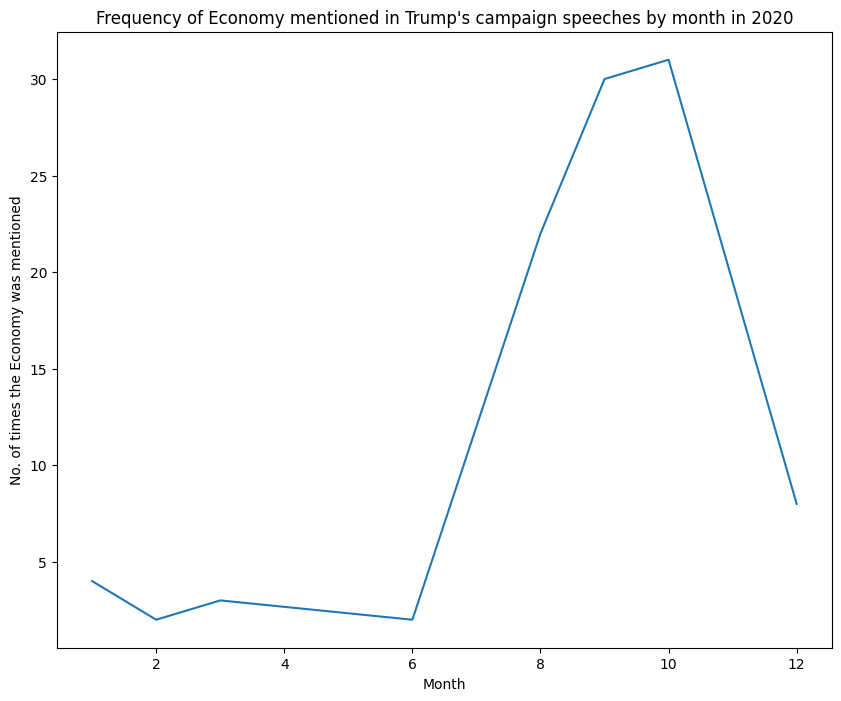

In [55]:
count_words(economy_top10, 'Economy')

Total mentions of Healthcare: 509 
mean    12.414634
std      7.990543
min      1.000000
25%      8.000000
50%     12.000000
75%     15.000000
max     37.000000
Name: health, dtype: float64


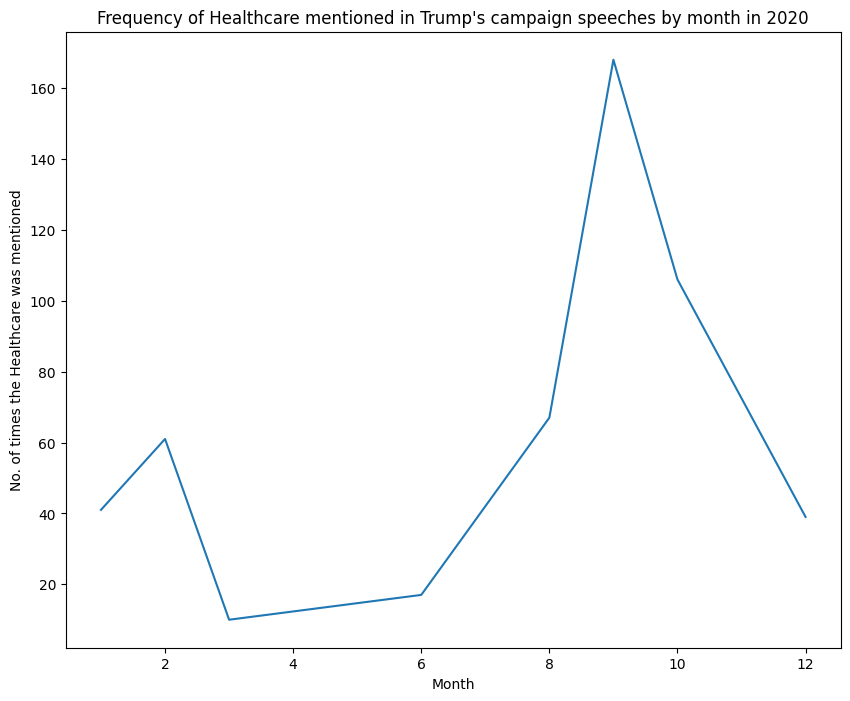

In [57]:
count_words(healthcare_top10, 'Healthcare')

Total mentions of Crime: 300 
mean     7.317073
std      4.535631
min      1.000000
25%      4.000000
50%      6.000000
75%     10.000000
max     17.000000
Name: criminal, dtype: float64


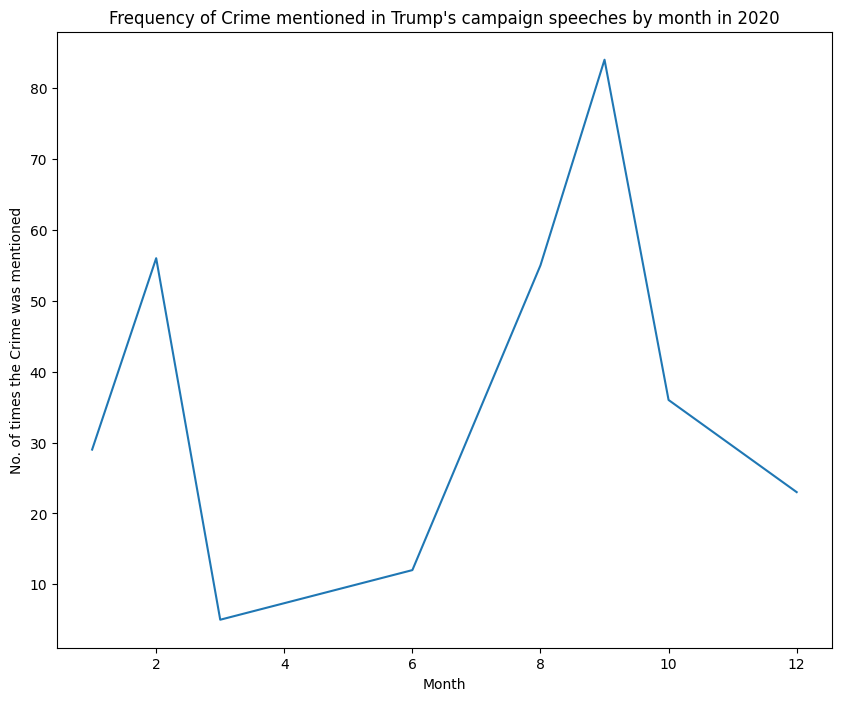

In [58]:
count_words(crime_top10, 'Crime')

Total mentions of Foreign Policy: 608 
mean    14.829268
std      6.476505
min      2.000000
25%     10.000000
50%     16.000000
75%     19.000000
max     31.000000
Name: policies, dtype: float64


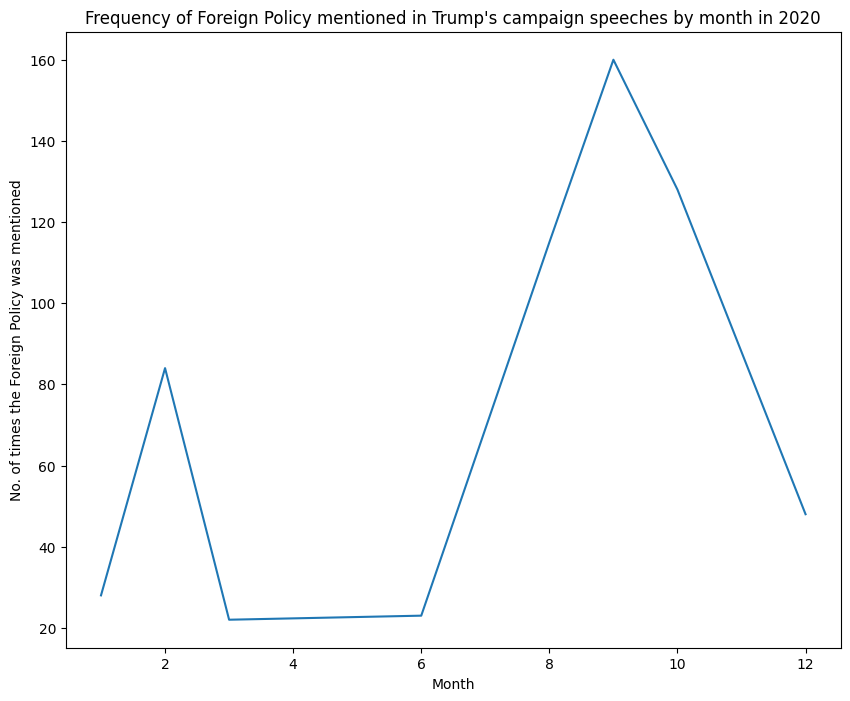

In [67]:
count_words(foreign_policy_top10, 'Foreign Policy')

Total mentions of Immigration: 777 
mean    18.951220
std      8.006095
min      1.000000
25%     14.000000
50%     20.000000
75%     24.000000
max     36.000000
Name: immigrants, dtype: float64


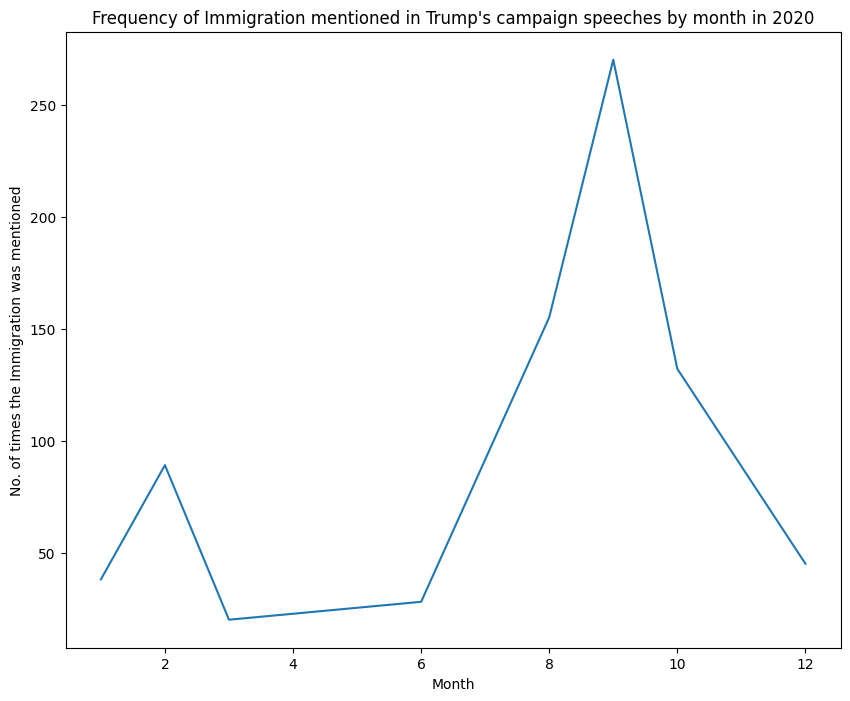

In [68]:
count_words(immigration_top10, 'Immigration')

# Finding average sentence length

In [85]:
def avg_sentence_length_per_speech(df):
    speech_sentence_lengths = []
    for speech in df['Speech']:
        sentences = nltk.sent_tokenize(speech)  # Sentence segmentation with NLTK
        sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in sentences]
        avg_length = np.mean(sentence_lengths) if sentence_lengths else 0  # Handle empty speeches
        speech_sentence_lengths.append(avg_length)

    return pd.Series(speech_sentence_lengths, index=df.index)

avg_lengths_series = avg_sentence_length_per_speech(df)

# We then created a new column in the dataframe with the Average Sentence Length per Speech
df['Mean Sentence Length (Words)'] = avg_lengths_series
# df = df.drop(columns=['Mean Sentence Length(Words)'])

sent_summary_stats = df['Mean Sentence Length (Words)'].describe().to_frame().T
filtered_stats = sent_summary_stats.drop(columns=['count']) # Drop the 'count' column instead
filtered_stats.index = ['Mean Sentence Length (Words)']
filtered_stats

,mean,std,min,25%,50%,75%,max
Mean Sentence Length (Words),14.543913,1.674389,12.348837,13.157321,14.300178,15.695712,18.962085






# Analysing Distinguishing Terms


In [ ]:
df['Month'] = df['Date'].dt.month
df.head()

In [ ]:
import scattertext as st

# create a corpus of text from the dataframe
corpus = st.CorpusFromPandas(df, # load the dataframe
                             category_col='Month', # indicate which column contains the category we want to distinguish by
                             text_col='Speech', # indicate which column stores the text to be analyzed
                             nlp=nlp).build() # load the NLP models used for analysis

# remove stopwords from the corpus of text
corpus=corpus.remove_terms(nlp.Defaults.stop_words, ignore_absences=True)

# now, we create the scatterplot
html = st.produce_scattertext_explorer(
                   corpus, # load the corpus
                   category="8", # indicate which category value we want to compare against all others; in this case, all rows in which "REX TILLERSON" is the speaker
                   category_name='August', # set the label on the plot as "Rex Tillerson"
                   not_category_name='Others', # set the label on the plot for all other speakers as "Others"
                   width_in_pixels=1000) #set the width

In [ ]:
# display the plot
display(HTML(html))

# Sentiment Analysis

In [ ]:
def get_sentiment_scores_batch(texts):
    docs = nlp.pipe(texts)  # Process all texts in batch
    polarity_scores = [doc._.blob.polarity for doc in docs]
    return polarity_scores
# Apply the function to the 'Speech' column and create new columns
df['Polarity'] = get_sentiment_scores_batch(df['Speech']) # Assign the results directly to 'Polarity' column
df.head()


In [ ]:
sorted_polarity = df.sort_values(by=['Polarity'], ascending=False)
sorted_polarity.head()

In [ ]:
# Ensure 'Date' column is of datetime type:
df['Date'] = pd.to_datetime(df['Date'])

# Create the scatter plot:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(df['Date'], df['Polarity'], label='Polarity')

# Customize the plot:
plt.xlabel('Date')
plt.ylabel('Polarity Score')
plt.title('Polarity Scores Over Time (Scatter Plot)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot:
plt.show()

# Topic Modelling: LDA Method

In [86]:
all_speeches_text = " ".join(df['Speech'].tolist())

In [97]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import contractions

# Function to expand contractions before passing to CountVectorizer
def expand_contractions(text):
    return contractions.fix(text)

# Sample multi-document corpus
documents = df['Speech']

# Expand contractions in the documents
expanded_documents = [expand_contractions(doc) for doc in documents]

# Preprocessing and vectorization pipeline
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(expanded_documents)

# Apply NMF with adjusted max_iter and tol
nmf = NMF(n_components=7, max_iter=1000, tol=1e-4, init='nndsvd', random_state=42)  # Increased max_iter and set init method
nmf.fit(X)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Function to find the words most affiliated with a given input word
def find_affiliated_words(input_word, nmf, vectorizer, n_top_words=15):
    if input_word not in vectorizer.get_feature_names_out():
        print(f"The word '{input_word}' is not in the vocabulary.")
        return

    word_index = vectorizer.get_feature_names_out().tolist().index(input_word)
    topic_word_dist = nmf.components_

    topic_weights = topic_word_dist[:, word_index]
    most_affiliated_topic = np.argmax(topic_weights)

    print(f"The word '{input_word}' is most affiliated with Topic #{most_affiliated_topic + 1}")

    # Get the top words for this topic
    top_word_indices = topic_word_dist[most_affiliated_topic].argsort()[:-n_top_words - 1:-1]
    top_words = [words[i] for i in top_word_indices]

    return top_words

# Check with 'economy'
top_words_for_economy = find_affiliated_words("economy", nmf, vectorizer)
print("Words most affiliated with 'economy':", top_words_for_economy)



The word 'economy' is most affiliated with Topic #2
Words most affiliated with 'economy': ['biden', 'china', 'america', 'country', 'joe', 'thank', 'want', 'years', 'american', 'know', 'did', 'great', 'jobs', 'world', 'new']


In [98]:
top_words_for_healthcare = find_affiliated_words("healthcare", nmf, vectorizer)
print("Words most affiliated with 'healthcare':", top_words_for_healthcare)


The word 'healthcare' is most affiliated with Topic #3
Words most affiliated with 'healthcare': ['great', 'people', 'right', 'new', 'want', 'years', 'going', 'american', 'thank', 'know', 'country', 'america', 'party', 'like', 'did']


In [99]:
top_words_for_crime = find_affiliated_words("crime", nmf, vectorizer)
print("Words most affiliated with 'crime':", top_words_for_crime)


The word 'crime' is most affiliated with Topic #5
Words most affiliated with 'crime': ['going', 'people', 'want', 'did', 'like', 'know', 'right', 'just', 'great', 'think', 'way', 'doing', 'years', 'say', 'country']


In [108]:
def find_and_display_affiliated_words(input_words, nmf, vectorizer, n_top_words=10):
    """
    Finds the words most affiliated with topics for a list of input words and displays the results.
    Also determines and displays the most popular topic overall.

    Args:
        input_words (list): List of input words to analyze.
        nmf (NMF): Trained NMF model.
        vectorizer (CountVectorizer): Trained CountVectorizer.
        n_top_words (int): Number of top words to display for each topic.

    Returns:
        None
    """
    results = {}
    topic_counts = {}  # Dictionary to count occurrences of each topic
    topic_word_dist = nmf.components_
    words = vectorizer.get_feature_names_out()

    for input_word in input_words:
        if input_word not in words:
            results[input_word] = f"'{input_word}' is not in the vocabulary."
            continue

        word_index = words.tolist().index(input_word)
        topic_weights = topic_word_dist[:, word_index]
        most_affiliated_topic = np.argmax(topic_weights)

        # Increment the topic count
        topic_counts[most_affiliated_topic] = topic_counts.get(most_affiliated_topic, 0) + 1

        # Get the top words for this topic
        top_word_indices = topic_word_dist[most_affiliated_topic].argsort()[:-n_top_words - 1:-1]
        top_words = [words[i] for i in top_word_indices]

        results[input_word] = {
            "Most Affiliated Topic": most_affiliated_topic + 1,
            "Top Words": top_words
        }

    # Find the most popular topic
    most_popular_topic = max(topic_counts, key=topic_counts.get, default=None)

    # Display the results
    for word, details in results.items():
        if isinstance(details, str):  # Handle missing words
            print(f"{word}: {details}")
        else:
            print(f"{word} is most affiliated with Topic #{details['Most Affiliated Topic']}")
            print(f"Top words: {', '.join(details['Top Words'])}")
            print()

    # Display the most popular topic overall
    if most_popular_topic is not None:
        print(f"The overall most popular topic is Topic #{most_popular_topic + 1}")
    else:
        print("No topics were affiliated with the input words.")



In [109]:
input_words = economy_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

economic is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

growth is most affiliated with Topic #4
Top words: said, going, people, great, say, got, right, know, did, think

recession is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

economies is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

recovery is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

downturn: 'downturn' is not in the vocabulary.
slowdown: 'slowdown' is not in the vocabulary.
slowing: 'slowing' is not in the vocabulary.
sector is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

crisis is most affiliated with Topic #4
Top words: said, going, people, great, say, got, right, know, did, think

The ov

In [110]:
input_words = healthcare_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

health is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

care is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

services is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

medicare is most affiliated with Topic #4
Top words: said, going, people, great, say, got, right, know, did, think

medical is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

insurance is most affiliated with Topic #6
Top words: thank, great, going, people, want, said, black, know, country, like

education is most affiliated with Topic #4
Top words: said, going, people, great, say, got, right, know, did, think

provider: 'provider' is not in the vocabulary.
providers is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american

In [111]:
input_words = crime_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

criminal is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

crimes is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

murder is most affiliated with Topic #6
Top words: thank, great, going, people, want, said, black, know, country, like

trafficking is most affiliated with Topic #7
Top words: said, people, did, going, right, know, got, great, like, think

terrorism is most affiliated with Topic #4
Top words: said, going, people, great, say, got, right, know, did, think

homicide: 'homicide' is not in the vocabulary.
corruption is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

criminals is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

gang is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, amer

In [112]:
input_words = foreign_policy_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

policies is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

government is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

affairs is most affiliated with Topic #5
Top words: going, people, want, did, like, know, right, just, great, think

administration is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

economic is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

finance is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

security is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

official is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

min

In [113]:
input_words = immigration_top10
find_and_display_affiliated_words(input_words, nmf, vectorizer)

immigrants is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

naturalization: 'naturalization' is not in the vocabulary.
enforcement is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

legislation is most affiliated with Topic #6
Top words: thank, great, going, people, want, said, black, know, country, like

laws is most affiliated with Topic #1
Top words: said, know, did, going, right, like, got, great, think, people

immigrant is most affiliated with Topic #6
Top words: thank, great, going, people, want, said, black, know, country, like

law is most affiliated with Topic #2
Top words: biden, china, america, country, joe, thank, want, years, american, know

illegal is most affiliated with Topic #3
Top words: great, people, right, new, want, years, going, american, thank, know

legal is most affiliated with Topic #4
Top words: said, going, people, great, say, 